In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import norm
from tqdm.auto import tqdm

import sys
sys.path.append('../utils')
from utils import *

In [15]:
combined_df = retrieve_data()
combined_df.head()

,Date,ROG_Last_Price,ROG_IVOL,CFR_Last_Price,CFR_IVOL,ZURN_Last_Price,ZURN_IVOL,Risk_Free_Rate
0,2023-10-25,237.55,17.6858,107.00,33.0793,426.4,15.7900,1.4594
1,2023-10-26,237.25,17.9504,104.45,33.5406,426.8,15.9736,1.4508
2,2023-10-27,237.75,19.6028,104.40,33.4355,424.4,16.3945,1.4478
3,2023-10-30,241.30,19.3503,104.75,33.1531,428.2,15.9477,1.4623
4,2023-10-31,233.85,19.2518,106.90,32.7788,430.6,15.7948,1.4489


In [16]:
combined_df.iloc[187:189, :]

,Date,ROG_Last_Price,ROG_IVOL,CFR_Last_Price,CFR_IVOL,ZURN_Last_Price,ZURN_IVOL,Risk_Free_Rate
187,2024-07-25,277.5,18.2666,131.2,23.4150,474.6,14.5858,0.8649
188,2024-07-26,286.0,19.3426,134.9,22.7266,478.8,14.5597,0.8657


In [17]:
# simulate from 25/7 to end (Dec): future risk-free?

In [18]:
np.random.seed(42)
n_days = 252
dt = 1 / n_days

close = combined_df[['ROG_Last_Price', 'CFR_Last_Price', 'ZURN_Last_Price']]
close.cov()

,ROG_Last_Price,CFR_Last_Price,ZURN_Last_Price
ROG_Last_Price,375.344673,-17.563543,286.937174
CFR_Last_Price,-17.563543,133.176550,138.191785
ZURN_Last_Price,286.937174,138.191785,706.118284


In [19]:
tickers = close.columns
log_returns = np.log((close / close.shift(1)).dropna())
log_returns.iloc[186:, :]

,ROG_Last_Price,CFR_Last_Price,ZURN_Last_Price
187,0.014519,-0.016629,0.000000
188,0.030171,0.027811,0.008811
189,-0.002100,-0.011182,0.000000
190,0.000350,0.006352,0.011422
191,0.001050,-0.001864,-0.002274
...,...,...,...
248,-0.001465,-0.006297,-0.002278
249,-0.002568,0.002366,-0.011084
250,0.018202,-0.007115,-0.001538
251,0.009336,0.018861,0.001923


In [35]:
log_returns.iloc[(0 - 90):0, :].cov() * n_days

/home/bach/anaconda3/envs/mh4518/lib/python3.11/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/bach/anaconda3/envs/mh4518/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/bach/anaconda3/envs/mh4518/lib/python3.11/site-packages/pandas/core/frame.py:11211: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/bach/anaconda3/envs/mh4518/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/bach/anaconda3/envs/mh4518/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


,ROG_Last_Price,CFR_Last_Price,ZURN_Last_Price
ROG_Last_Price,NaN,NaN,NaN
CFR_Last_Price,NaN,NaN,NaN
ZURN_Last_Price,NaN,NaN,NaN


In [ ]:
# Simulating from start
# Assume covariance matrix is constant
# Window sliding: last 90 days

def MultivariateGBMSimulation(
    s0=close.iloc[0], 
    tickers=tickers,
    dt=dt,
    drift=0.01,
    n_paths=100,
    # T=1, # Time horizon in year:
    variance_reduction=None,
    last_id=287,
    current_id=187,
    window_size=30,
    ):

    volatility=log_returns.iloc[(current_id - window_size):current_id, :].cov() * n_days   
    T = dt * (last_id - current_id)
    n_steps = int(T / dt)
    result = np.zeros((len(tickers), n_paths, n_steps))

    if variance_reduction==None:
        for i in tqdm(range(n_paths)):
            choleskyMatrix = np.linalg.cholesky(volatility)
            e = np.random.normal(size=(len(tickers), n_steps)) # Generate RV for steps

            for j in range(n_steps):
                for k in range(len(tickers)):
                    if(j==0):
                        result[k, i, j] = s0[tickers[k]]
                    else:
                        if isinstance(drift, np.ndarray):
                            result[k, i, j] = result[k, i, j-1] * np.exp(
                                (drift[j] -  1/2 * np.sqrt(volatility.iloc[k, k])) * dt + 
                                np.sqrt(dt) * choleskyMatrix[k, k] * e[k, j]) 
                        else:
                            result[k, i, j] = result[k, i, j-1] * np.exp(
                                (drift -  1/2 * np.sqrt(volatility.iloc[k, k])) * dt + 
                                np.sqrt(dt) * choleskyMatrix[k, k] * e[k, j])
                        
    elif variance_reduction=='av':
        for i in tqdm(range(n_paths // 2)):
            choleskyMatrix = np.linalg.cholesky(volatility)
            e = np.random.normal(size=(len(tickers), n_steps)) # Generate RV for steps
            e_tilde = -e    

            for j in range(n_steps):
                for k in range(len(tickers)):
                    if(j==0):
                        result[k, i, j] = s0[tickers[k]]
                        result[k, n_paths - i - 1, j] = s0[tickers[k]]

                    else:
                        if isinstance(drift, np.ndarray):
                            result[k, i, j] = result[k, i, j-1] * np.exp(
                                (drift[j] -  1/2 * np.sqrt(volatility.iloc[k, k])) * dt + 
                                np.sqrt(dt) * choleskyMatrix[k, k] * e[k, j])
                            result[k, n_paths - i - 1, j] = result[k, n_paths - i - 1, j-1] * np.exp(
                                (drift[j] -  1/2 * np.sqrt(volatility.iloc[k, k])) * dt + 
                                np.sqrt(dt) * choleskyMatrix[k, k] * e_tilde[k, j])
                        else:
                            result[k, i, j] = result[k, i, j-1] * np.exp(
                                (drift -  1/2 * np.sqrt(volatility.iloc[k, k])) * dt + 
                                np.sqrt(dt) * choleskyMatrix[k, k] * e[k, j])
                            result[k, n_paths - i - 1, j] = result[k, n_paths - i - 1, j-1] * np.exp(
                                (drift -  1/2 * np.sqrt(volatility.iloc[k, k])) * dt + 
                                np.sqrt(dt) * choleskyMatrix[k, k] * e_tilde[k, j])
                            
    elif variance_reduction=='emc':
        for i in tqdm(range(n_paths)):
            choleskyMatrix = np.linalg.cholesky(volatility)
            e = np.random.normal(size=(len(tickers), n_steps)) # Generate RV for steps

            for j in range(n_steps):
                for k in range(len(tickers)):
                    if(j==0):
                        result[k, i, j] = s0[tickers[k]]
                    else:
                        if isinstance(drift, np.ndarray):
                            result[k, i, j] = result[k, i, j-1] * np.exp(
                                (drift[j] -  1/2 * np.sqrt(volatility.iloc[k, k])) * dt + 
                                np.sqrt(dt) * choleskyMatrix[k, k] * e[k, j])
                        else:
                            result[k, i, j] = result[k, i, j-1] * np.exp(
                                (drift -  1/2 * np.sqrt(volatility.iloc[k, k])) * dt + 
                                np.sqrt(dt) * choleskyMatrix[k, k] * e[k, j])
        for k in range(len(tickers)):  
                # path, step
            correction_factor = result[k][-1, :].mean() / result[k][-1, :] 
            result[k] = result[k] * correction_factor                    
           
    return result, tickers

In [46]:
combined_df.iloc[50]['Date'], combined_df.iloc[60]['Date']

(Timestamp('2024-01-09 00:00:00'), Timestamp('2024-01-23 00:00:00'))

In [47]:
last_id = 287

prices = []
for current_id in tqdm(range(50, 61)):
    payoff = []
    result, _ = MultivariateGBMSimulation(s0=close.iloc[current_id], n_paths=1000, variance_reduction='av', current_id=current_id, window_size=30)
    
    old_path_rog = combined_df['ROG_Last_Price'].iloc[:current_id]
    old_path_cfr = combined_df['CFR_Last_Price'].iloc[:current_id]
    old_path_zurn = combined_df['ZURN_Last_Price'].iloc[:current_id]

    for i in range(result.shape[1]):
        path_rog = np.append(old_path_rog, result[0][i].flatten())
        path_cfr = np.append(old_path_cfr, result[1][i].flatten())
        path_zurn = np.append(old_path_zurn, result[2][i].flatten())

        payoff.append(payoff_func(path_rog, path_cfr, path_zurn, combined_df.iloc[current_id]['Date'], verbose=False))
    
    prices.append(neutral_pricing(np.mean(payoff), 0.01107, last_id - current_id))



  0%|          | 0/11 [00:00<?, ?it/s]

20 50
                 ROG_Last_Price  CFR_Last_Price  ZURN_Last_Price
ROG_Last_Price         0.032328       -0.008216         0.008886
CFR_Last_Price        -0.008216        0.057804        -0.005270
ZURN_Last_Price        0.008886       -0.005270         0.008751


  0%|          | 0/500 [00:00<?, ?it/s]

21 51
                 ROG_Last_Price  CFR_Last_Price  ZURN_Last_Price
ROG_Last_Price         0.032257       -0.008291         0.008386
CFR_Last_Price        -0.008291        0.057903        -0.004974
ZURN_Last_Price        0.008386       -0.004974         0.009040


  0%|          | 0/500 [00:00<?, ?it/s]

22 52
                 ROG_Last_Price  CFR_Last_Price  ZURN_Last_Price
ROG_Last_Price         0.034197       -0.006233         0.009324
CFR_Last_Price        -0.006233        0.058837        -0.003475
ZURN_Last_Price        0.009324       -0.003475         0.009292


  0%|          | 0/500 [00:00<?, ?it/s]

23 53
                 ROG_Last_Price  CFR_Last_Price  ZURN_Last_Price
ROG_Last_Price         0.033703       -0.006554         0.009799
CFR_Last_Price        -0.006554        0.058769        -0.003585
ZURN_Last_Price        0.009799       -0.003585         0.010076


  0%|          | 0/500 [00:00<?, ?it/s]

24 54
                 ROG_Last_Price  CFR_Last_Price  ZURN_Last_Price
ROG_Last_Price         0.034005       -0.007877         0.009330
CFR_Last_Price        -0.007877        0.051547        -0.004301
ZURN_Last_Price        0.009330       -0.004301         0.010215


  0%|          | 0/500 [00:00<?, ?it/s]

25 55
                 ROG_Last_Price  CFR_Last_Price  ZURN_Last_Price
ROG_Last_Price         0.034218       -0.007159         0.009014
CFR_Last_Price        -0.007159        0.053312        -0.005454
ZURN_Last_Price        0.009014       -0.005454         0.010670


  0%|          | 0/500 [00:00<?, ?it/s]

26 56
                 ROG_Last_Price  CFR_Last_Price  ZURN_Last_Price
ROG_Last_Price         0.035637       -0.004517         0.011292
CFR_Last_Price        -0.004517        0.058098        -0.001557
ZURN_Last_Price        0.011292       -0.001557         0.013427


  0%|          | 0/500 [00:00<?, ?it/s]

27 57
                 ROG_Last_Price  CFR_Last_Price  ZURN_Last_Price
ROG_Last_Price         0.034367       -0.010837         0.011528
CFR_Last_Price        -0.010837        0.142020        -0.009407
ZURN_Last_Price        0.011528       -0.009407         0.014088


  0%|          | 0/500 [00:00<?, ?it/s]

28 58
                 ROG_Last_Price  CFR_Last_Price  ZURN_Last_Price
ROG_Last_Price         0.028428       -0.011497         0.009478
CFR_Last_Price        -0.011497        0.141949        -0.009686
ZURN_Last_Price        0.009478       -0.009686         0.014636


  0%|          | 0/500 [00:00<?, ?it/s]

29 59
                 ROG_Last_Price  CFR_Last_Price  ZURN_Last_Price
ROG_Last_Price         0.027332       -0.011504         0.010518
CFR_Last_Price        -0.011504        0.142184        -0.008819
ZURN_Last_Price        0.010518       -0.008819         0.016800


  0%|          | 0/500 [00:00<?, ?it/s]

30 60
                 ROG_Last_Price  CFR_Last_Price  ZURN_Last_Price
ROG_Last_Price         0.029416       -0.013173         0.011551
CFR_Last_Price        -0.013173        0.142505        -0.010373
ZURN_Last_Price        0.011551       -0.010373         0.016794


  0%|          | 0/500 [00:00<?, ?it/s]

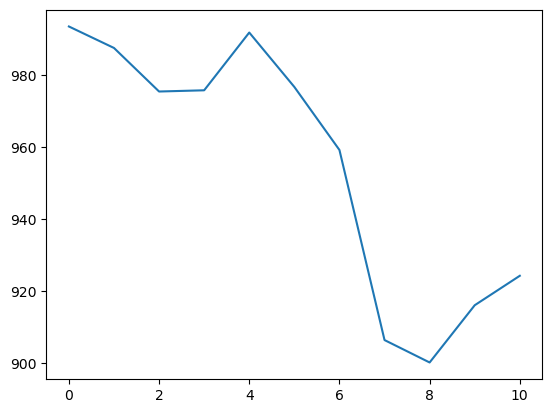

In [48]:
plt.plot(prices)

NameError: name 'result_av' is not defined

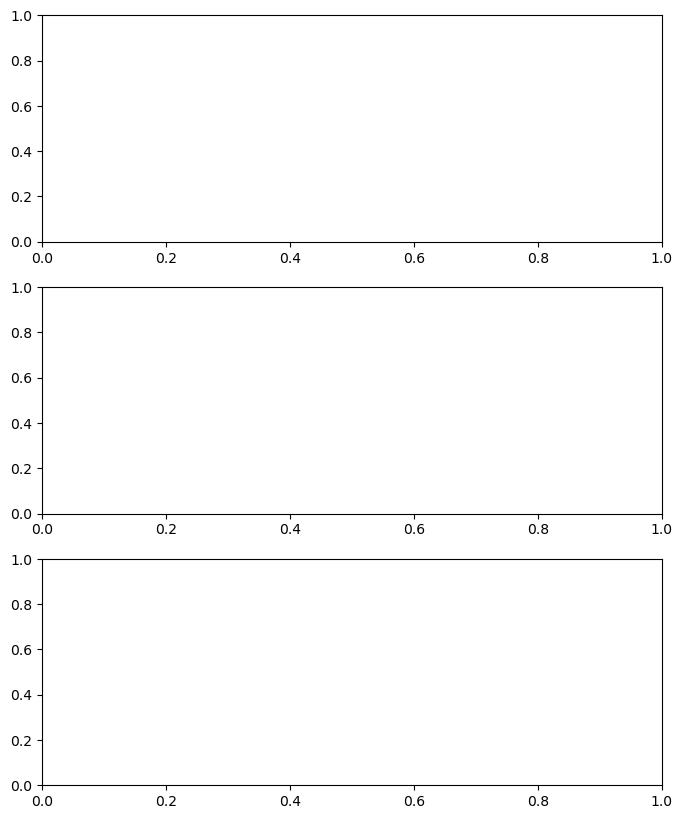

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10))

for i in range(100):
    axes[0].plot(result_av[0][i], lw=1)
axes[0].set_title('Simulated Asset Price Paths for Roche (25/07/2024 - 25/10/2024)')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Asset Price')

for i in range(100):
    axes[1].plot(result_av[1][i], lw=1)
axes[1].set_title('Simulated Asset Price Paths for Richemont (25/07/2024 - 25/10/2024)')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Asset Price')

for i in range(100):
    axes[2].plot(result_av[2][i], lw=1)
axes[2].set_title('Simulated Asset Price Paths for Zurich (25/07/2024 - 25/10/2024)')
axes[2].set_xlabel('Days')
axes[2].set_ylabel('Asset Price')

plt.tight_layout()
plt.show()

In [ ]:
payoff = []
payoff_av = []
payoff_emc = []

old_path_rog = combined_df['ROG_Last_Price'].iloc[:current_id]
old_path_cfr = combined_df['CFR_Last_Price'].iloc[:current_id]
old_path_zurn = combined_df['ZURN_Last_Price'].iloc[:current_id]

for i in range(result.shape[1]):
    path_rog = np.append(old_path_rog, result[0][i].flatten())
    path_cfr = np.append(old_path_cfr, result[1][i].flatten())
    path_zurn = np.append(old_path_zurn, result[2][i].flatten())

    payoff.append(payoff_func(path_rog, path_cfr, path_zurn))


Hello
Worst performance: 0.8531716292523017
Barrier event reached: False
Close above initial: 2
Hello
Worst performance: 0.7472722707474906
Barrier event reached: False
Close above initial: 1
Hello
Worst performance: 0.8169978983237324
Barrier event reached: False
Close above initial: 1
Hello
Worst performance: 0.9217838744239558
Barrier event reached: False
Close above initial: 2
Hello
Worst performance: 0.8148986155204433
Barrier event reached: False
Close above initial: 2
Hello
Worst performance: 0.7695978031052945
Barrier event reached: False
Close above initial: 0
Hello
Worst performance: 0.9449811284699465
Barrier event reached: False
Close above initial: 1
Hello
Worst performance: 0.9576709537322279
Barrier event reached: False
Close above initial: 1
Hello
Worst performance: 0.7823570907531662
Barrier event reached: False
Close above initial: 2
Hello
Worst performance: 0.7389509338205191
Barrier event reached: False
Close above initial: 1
Hello
Worst performance: 0.7531608652197

In [ ]:
np.mean(payoff), np.std(payoff)

(1086.6672018410513, 18.608194826059837)

In [ ]:
neutral_pricing(np.mean(payoff), 0.01, last_id - current_id)

1078.6332864984772